## Decomposing SST Reviews into subphrases of opposite sentiments

In [1]:
from torchtext import data, datasets
import torch
import os
from collections import Counter
import torch.nn.functional as F
import torch.autograd as autograd
import torch.nn as nn
import numpy as np
from ContextualDecomposition import CD

## Extract Data

In [2]:
inputs = data.Field(lower='preserve-case')
answers = data.Field(sequential=False, unk_token=None) # y: floats
train, dev, test = datasets.SST.splits(inputs, answers, fine_grained = False, train_subtrees = True)
inputs.build_vocab(train, dev, test)
inputs.vocab.load_vectors('glove.6B.300d')
answers.build_vocab(train)

/home/ckerriou/anaconda2/lib/python2.7/site-packages/nltk/tree.py:623: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif token == close_b:
/home/ckerriou/anaconda2/lib/python2.7/site-packages/nltk/tree.py:616: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if token[0] == open_b:


In [3]:
model =  torch.load('model.pt', map_location=lambda storage, loc: storage)

## Parse the reviews into positive and negative review with opposing sentiment subsentences

In [4]:
def parseTrees(train):
    # Output two list: Positive reviews, Negative reviews with opposing sentiment subsentences
    # List of tuples: (sentence, list of subsentence) where subsentences are of opposing sentiment to sentence.
    # The subsentences are of lengths 1/3 and 2/3 of the given sentence
    positivels = []
    negativels = []
    cur_sentence = []
    for _,sub in enumerate(train):
        # check if sub is subsentence of curr_sentence
        if set(sub.text).issubset(set(cur_sentence)):
            l = len(sub.text)
            # Check if length of subtree is between 1/3 and 2/3
            if (l <= cur_length*2/3.0) and (l >= cur_length/3.0) :
                # get sentiment of subsentence
                sentiment = sub.label
                # add subsentence to corresponding list, want opposing sentiment subphrases
                if sentiment == 'positive' and cur_sentiment == 'negative':
                    negativels[-1][1].append(sub)
                elif sentiment == 'negative' and cur_sentiment == 'positive':
                    positivels[-1][1].append(sub)
        else:
            cur_sentiment = sub.label
            if cur_sentiment == 'negative':
                negativels.append((sub, []))
            elif cur_sentiment == 'positive':
                positivels.append((sub,[]))
            cur_sentence = sub.text
            cur_length = len(cur_sentence)

    # remove all sentence with empty subphrase list
    pls = []
    nls = []
    for e in positivels:
        if len(e[1]): pls.append(e)
    for e in negativels:
        if len(e[1]): nls.append(e)
            
    return [pls, nls]

## Format the lists for the CD

In [5]:
def rolling_window(phrase, sub):
    tups = []
    for i in range(phrase.shape[0]):
        if i + len(sub) > phrase.shape[0]:
            break
        else:
            if np.array_equal(phrase[i:i+len(sub)], sub):
                tups.append((i, i+len(sub)-1))
    return tups

In [6]:
def format_indices(ls):
    formatted_ls = []
    for tup in ls:
        phrase = inputs.numericalize([tup[0].text], device=-1, train=False)
        subphrases = [inputs.numericalize([sub.text], device=-1, train=False) for sub in tup[1]]
        np_phrase = phrase.data.numpy()
        idx_tups = []
        for sub in subphrases:
            np_sub = sub.data.numpy()
            idx_tups += rolling_window(np_phrase, np_sub)
        formatted_ls.append((phrase, idx_tups))
    return formatted_ls

In [7]:
plsR, nlsR = parseTrees(train)


In [10]:
pls = format_indices(plsR)
nls = format_indices(nlsR)

In [11]:
# Input: list of phrase and corresponding subphrases
#        label of list: positive or negative phrases (with opposite sentiment subphrases)
#        model
def findSubphraseScores(ls, label, model):
    output = []
    for phrase, subIndexList in ls:
        for start,stop in subIndexList:
            e = CD(phrase, model, start, stop)
            output.append(e[0][0]-e[0][1])
    return output

def findSubphraseScoresNoSubtraction(ls, label, model):
    output = []
    for phrase, subIndexList in ls:
        for start,stop in subIndexList:
            e = CD(phrase, model, start, stop)
            if label == 'positive':
                output.append(e[0][0])
                
            elif label == 'negative':
                output.append(e[0][1])
    return output

In [12]:
plsScores = findSubphraseScores(pls, 'positive', model)
nlsScores = findSubphraseScores(nls, 'negative', model)

Text(0.5,1,u'Distribution of positive and negative dissenting sub-phrases')

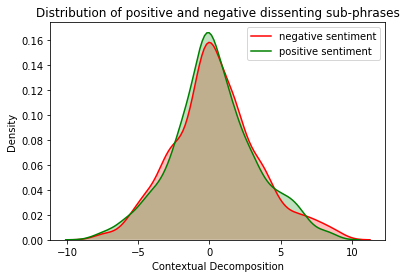

In [14]:
import seaborn as sns
ax = sns.distplot(nlsScores, hist=False, color="red", kde_kws={"shade":True}, label="negative sentiment");
ax = sns.distplot(plsScores, hist=False, color="green", kde_kws={"shade":True}, label="positive sentiment");

ax.set(xlabel='Contextual Decomposition', ylabel='Density')
ax.set_title("Distribution of positive and negative dissenting sub-phrases")


In [20]:
from scipy import stats
rvs1 = plsScores
rvs2 = nlsScores
kolmogorovScore = stats.ks_2samp(rvs1, rvs2)[0]
print("The two-sample Kolmogorov-Smirnov score is %f." %kolmogorovScore)
print("The authors score is 0.74")


The two-sample Kolmogorov-Smirnov score is 0.035106.
The authors score is 0.74


### Example phrases and corresponding scores

In [125]:
x = inputs.numericalize([["A"], ["painfully"], ["funny"], ["ode"], ["to"], ["bad"], ["behaviour"], ["."]], device=-1, train=False)
y = inputs.numericalize([["A"], ["bad"], ["movie"], ["."]], device=-1, train=False)


In [127]:
xx = CDAuthor(x,model,0,3)
yy = CDAuthor(y,model,0,3)

print(xx[0][0]-xx[0][1])
print(yy[0][0]-yy[0][1])

3.745513772380719
3.365864613372511


## Example of sentence with opposing sentiment subsentence

In [9]:
sentence, subls = plsR[50]
subls = subls[0]

print("Sentence")
print(sentence.text)
print(sentence.label)
print("Subsentence")
print(subls.text)
print(subls.label)

Sentence
[u'while', u'it', u'can', u'be', u'a', u'bit', u'repetitive', u',', u'overall', u'it', u"'s", u'an', u'entertaining', u'and', u'informative', u'documentary', u'.']
positive
Subsentence
[u'while', u'it', u'can', u'be', u'a', u'bit', u'repetitive']
negative
